# Discrete-Time Fourier Transform (DTFT) applied on real-world graph

> The goal of this notebook is to use DTFT to model temporal interactions in a graph.

More information about Fourier Transform [here](https://pythonnumericalmethods.berkeley.edu/notebooks/chapter24.01-The-Basics-of-waves.html). Notes about this page at the end of this notebook.

**Libraries**

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import torch
import dgl
from dgl.data.utils import load_graphs

Using backend: pytorch


## 1. Data

Data comes from [SFHH Conference Dataset](http://www.sociopatterns.org/datasets/sfhh-conference-data-set/).   
It is represented as a **link stream**, where each entry is a triplet $(t, i, j)$, with $i$ and $j$ are two nodes of a link and $t$ the time at which the link existed.

In [2]:
PATH = '../data'

**Raw data**  

Let's have a look at the original data.

In [3]:
df = pd.read_csv(f'{PATH}/data/tij_SFHH.dat_', header=None, names=['t', 'i', 'j'], delimiter=' ') # SF2H conference
print(f'Raw data shape : {df.shape}')
print(df.head())

Raw data shape : (70261, 3)
       t     i     j
0  32520  1467  1591
1  32560  1513  1591
2  32700  1591  1467
3  32720  1591  1467
4  32740  1591  1467


**Preprocessed data**  

Preprocessing consists in :
* reindexing nodes from label 0 to $|V|$. These new values are stored in `src` and `dest` columns

In [4]:
PREPROC_PATH = '../preprocessed_data'
df_preproc = pd.read_pickle(f'{PREPROC_PATH}/preprocessed_data/SF2H.pkl')
print(f'Preprocessed data shape : {df_preproc.shape}')
print(df_preproc.head())

Preprocessed data shape : (70261, 5)
       t     i     j  src  dest
0  32520  1467  1591   36   144
1  32560  1513  1591   75   144
2  32700  1591  1467  144    36
3  32720  1591  1467  144    36
4  32740  1591  1467  144    36


## 2. Graph

Preprocessed data is transformed into a **graph** object, using `dgl` library :
* Source and destination nodes comes directly from `src` and `dest` columns in preprocessed dataframe.
* Time dimension is encoded on each edge, in `timestamp` variable 

In [5]:
# Source and destination nodes
src_tens = torch.tensor(df_preproc['src'].values)
dest_tens = torch.tensor(df_preproc['dest'].values)

# DGL graph
g = dgl.graph((src_tens, dest_tens))
g.edata['timestamp'] = torch.from_numpy(df_preproc['t'].to_numpy())

# GRAPH
print(f'DGL graph : {g}')
print(f"Timestamps : {g.edata['timestamp']}")

DGL graph : Graph(num_nodes=403, num_edges=70261,
      ndata_schemes={}
      edata_schemes={'timestamp': Scheme(shape=(), dtype=torch.int64)})
Timestamps : tensor([ 32520,  32560,  32700,  ..., 146820, 146820, 146820])


**Load splitted graphs**  

Splitted graphs are already computed. Let's load them.

In [6]:
glist = list(load_graphs(f"{PREPROC_PATH}/data.bin")[0])
train_g, train_pos_g, train_neg_g, val_pos_g, val_neg_g, test_pos_g, test_neg_g = glist

## 3. Dynamic representation of data

`dgl` graph encodes edges as a tuple of tensors containing each nodes forming these edges. For example, one can use the method `edges()` to display both source and destinations tensors of nodes (see below).

In [7]:
g.edges()

(tensor([ 36,  75, 144,  ..., 133,  79,  79]),
 tensor([144, 144,  36,  ...,  79, 165, 199]))

However, in order to proceed message passing via Graph Neural Network on this temporal data, we would like to represent the graph structure and its time dimension within a single object.  

For this purpose, we create a **3d-tensor**, with shape $(|V|, |V|, |T|)$, with $V$ the set of vertices and $T$ the set of timesteps in original data.  
This tensor reflects the occurences of edges over time. In other words, it contains information about interactions between nodes at every timestep, within a single structure. However, since data comes from a real-world problem (interactions between conference attendees), this structure will be sparse.

**Discrete-Time Fourier Transform (DTFT)** performs embedding of a discrete temporal signal into the frequency domain. Considering the temporal dimension (third dimension) in the tensor detailed above as a discrete temporal signal, we can use DTFT to compute its correspondig Fourier serie. As Fourier serie is a periodic continous function, we can then sample $N=|T|$ elements in the serie, in order to create a vector containing the frequency embedding of our original temporal signal. The results of this sample process is called the **Discrete Fourier Transform (DFT)** and can be seen as windowing the frequency domain. In practice, it is perform efficently through the **Fast Fourier Transform (FFT)** algorithm.

Each vector containing frequency embedding can be written as :
$$
A_{i, j}[k] = \sum_{t=0}^{T-1} a_{t} e^{-i \frac{2\pi}{N}tk}, k=0, ..., N-1 
$$
with $a$ the time-domain signal, $N$ the size of the frequency-domain embedding (we can consider for example that $N=|T|$). The *amplitude* of the spectrum is obtained with $|A|$ .


In [153]:
def DFT(g, timerange, df, N, add_self_edge=False):
    ''' Performs Discrete Fourier Transform of the number of interactions between nodes over time.

        Parameters
        ----------
            g : dgl graph
            df : DataFrame containing link stream with triplets (t, u, v)
            N : Size of sampling
            add_self_edge (default = False) : if True, add edges from one node to iteself
            
        Output
        ------
            3d tensor with shape (|V|, |V|, N)'''
    
    
    # Add edges between node and itself
    if add_self_edge:
        g.add_edges(g.nodes(), g.nodes())
    
    # Tensor initialization
    adj = torch.zeros(len(g.nodes()), len(g.nodes()), len(timerange))
    fourier_feat = torch.zeros(len(g.nodes()), len(g.nodes()), N)
    T_ = len(timerange)
    
    # For every pair of nodes, create a tensor with size len(timerange)
    # containing 1 if node exists (i.e if node is part of an edge) at time t
    # This tensor corresponds to the Discrete temporal signal
    for node_src, node_dest, time in zip(df['src'], df['dest'], df['t']):
        time_index = list(timerange).index(time)
        adj[node_src, node_dest, time_index] = 1
        
    # For each entry in the Discrete temporal signal, compute N samples (with N=T) at interval 2*pi / N
    for node_src in range(adj.shape[0]):
        for node_dest in range(adj.shape[1]):            
            X_temp = np.fft.fft(adj[node_src, node_dest, :], N)
            # When the input a is a time-domain signal and A = fft(a), np.abs(A) is its amplitude spectrum
            # Source : https://numpy.org/doc/stable/reference/routines.fft.html#module-numpy.fft
            fourier_feat[node_src, node_dest, :] = torch.from_numpy(np.abs(X_temp))
                
    return fourier_feat

**Compute DFT on training graph** 

In [106]:
%%time

# Training dataframe
max_train_time = int(train_pos_g.edata['timestamp'].max())
df_train = df_preproc[df_preproc['t']<=max_train_time]
train_timerange = np.arange(int(train_pos_g.edata['timestamp'].min()), int(train_pos_g.edata['timestamp'].max()) + 20, 20)

# Compute features
fourier_feat = DFT(train_pos_g, train_timerange, df_train, len(train_timerange), add_self_edge=False)

CPU times: user 3min 18s, sys: 18.1 s, total: 3min 36s
Wall time: 3min 34s


In [107]:
%%time

# Compute adjacency matrix as 3d-tensor for displaying (see below)
adj_3d = torch.zeros(len(train_pos_g.nodes()), len(train_pos_g.nodes()), len(train_timerange))

for node_src, node_dest, time in zip(df_train['src'], df_train['dest'], df_train['t']):
    time_index = list(train_timerange).index(time)
    adj_3d[node_src, node_dest, time_index] = 1

CPU times: user 31.6 s, sys: 3.06 s, total: 34.6 s
Wall time: 33.1 s


# of interactions for nodes (36, 144)  :  13
# of interactions for nodes (0, 24) :  17
# of interactions for nodes (325, 371) :  32


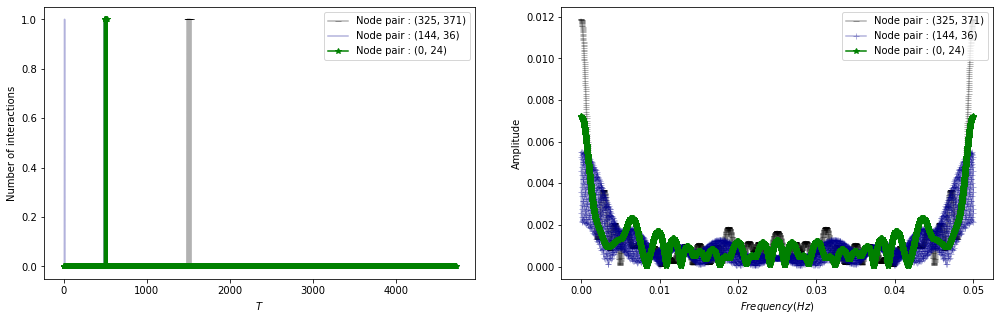

In [175]:
# Count number of interactions over time for pair of nodes
print('# of interactions for nodes (36, 144)  : ', df_preproc[(df_preproc['src']==144) & (df_preproc['dest']==36)].count()[0])
print('# of interactions for nodes (0, 24) : ', df_preproc[(df_preproc['src']==0) & (df_preproc['dest']==24)].count()[0])
print('# of interactions for nodes (325, 371) : ', df_preproc[(df_preproc['src']==325) & (df_preproc['dest']==371)].count()[0])

fig, ax = plt.subplots(1, 2, figsize=(17, 5))

N = len(train_timerange)
n = np.arange(N)
sr = 1/20 # timestep of 20 seconds in SF2H dataset
T = N/sr
freq = n/T

# Example of DTFT for a few pair of nodes
ax[1].plot(freq, fourier_feat[325, 371, :], label='Node pair : (325, 371)', alpha=0.3, color='black', marker='_')
ax[1].plot(freq, fourier_feat[144, 36, :], label='Node pair : (144, 36)', alpha=0.3, color='darkblue', marker='+')
ax[1].plot(freq, fourier_feat[0, 24, :], label='Node pair : (0, 24)', color='green', marker='*')
#plt.title('DTFT on on (with $N=T$)', weight='bold')
ax[1].legend(loc='upper right')
ax[1].set_xlabel('$Frequency (Hz)$')
ax[1].set_ylabel('Amplitude');

ax[0].plot(range(len(fourier_feat[325, 371, :])), adj_3d[325, 371, :], label='Node pair : (325, 371)', alpha=0.3, color='black', marker='_')
ax[0].plot(range(len(fourier_feat[144, 36, :])), adj_3d[144, 36, :], label='Node pair : (144, 36)', color='darkblue', alpha=0.3)
ax[0].plot(range(len(fourier_feat[0, 24, :])), adj_3d[0, 24, :], label='Node pair : (0, 24)', color='green', marker='*')

ax[0].legend(loc='upper right')
ax[0].set_ylabel('Number of interactions')
ax[0].set_xlabel('$T$');

# Save plot
#fig.savefig('img/DTFT.eps')

In [170]:
print(freq)

[0.0000e+00 5.0000e-02 1.0000e-01 ... 2.3555e+02 2.3560e+02 2.3565e+02]


**Order edges by descending number of interactions over time** 

In order to easily select potentially interesting edges in the dataset.

In [135]:
df_preproc.groupby(['src', 'dest']).count().sort_values('t', ascending=False)

t     i     j
src dest                  
195 211   1220  1220  1220
212 272    960   960   960
108 86     766   766   766
238 246    448   448   448
346 15     433   433   433
...        ...   ...   ...
169 334      1     1     1
    319      1     1     1
    287      1     1     1
    286      1     1     1
188 337      1     1     1

[9889 rows x 3 columns]

**Compare different edges**

# of interactions for nodes (36, 144)  :  13
# of interactions for nodes (0, 24) :  17
# of interactions for nodes (97, 85) :  325
# of interactions for nodes (212, 272) :  960


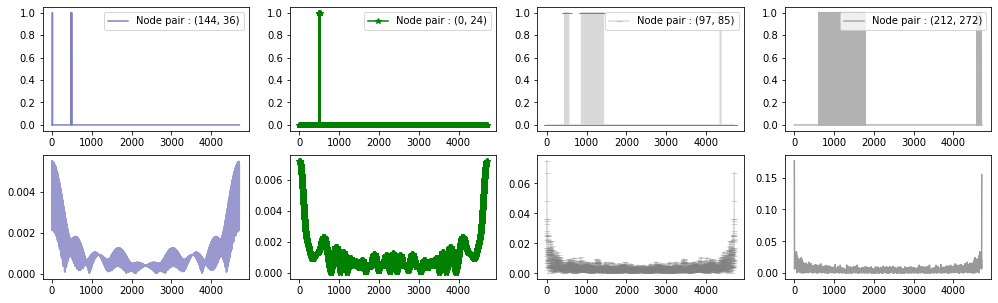

In [111]:
fig, ax = plt.subplots(2, 4, figsize=(17, 5))

# Count number of interactions over time for pair of nodes
print('# of interactions for nodes (36, 144)  : ', df_preproc[(df_preproc['src']==144) & (df_preproc['dest']==36)].count()[0])
print('# of interactions for nodes (0, 24) : ', df_preproc[(df_preproc['src']==0) & (df_preproc['dest']==24)].count()[0])
print('# of interactions for nodes (97, 85) : ', df_preproc[(df_preproc['src']==97) & (df_preproc['dest']==85)].count()[0])
print('# of interactions for nodes (212, 272) : ', df_preproc[(df_preproc['src']==212) & (df_preproc['dest']==272)].count()[0])


ax[0, 0].plot(range(len(fourier_feat[144, 36, :])), adj_3d[144, 36, :], label='Node pair : (144, 36)', color='darkblue', alpha=0.5)
ax[0, 1].plot(range(len(fourier_feat[0, 24, :])), adj_3d[0, 24, :], label='Node pair : (0, 24)', color='green', marker='*')
ax[0, 2].plot(range(len(fourier_feat[97, 85, :])), adj_3d[97, 85, :], label='Node pair : (97, 85)', alpha=0.3, color='grey', marker='_')
ax[0, 3].plot(range(len(fourier_feat[212, 272, :])), adj_3d[212, 272, :], label='Node pair : (212, 272)', alpha=0.3, color='black')

ax[1, 0].plot(range(len(fourier_feat[144, 36, :])), fourier_feat[144, 36, :], label='Node pair : (144, 36)', alpha=0.4, color='darkblue');
ax[1, 1].plot(range(len(fourier_feat[0, 24, :])), fourier_feat[0, 24, :], label='Node pair : (0, 24)', color='green', marker='*')
ax[1, 2].plot(range(len(fourier_feat[97, 85, :])), fourier_feat[97, 85, :], label='Node pair : (97, 85)', alpha=0.3, color='grey', marker='_')
ax[1, 3].plot(range(len(fourier_feat[212, 272, :])), fourier_feat[212, 272, :], label='Node pair : (212, 272)', alpha=0.4, color='black')

for i in range(4):
    ax[0, i].legend(loc='upper right')

In [172]:
N = len(train_timerange)
n = np.arange(N)
sr = 1 / 20
T = N / sr
f = n / T
f

array([0.00000000e+00, 1.06067034e-05, 2.12134069e-05, ...,
       4.99681799e-02, 4.99787866e-02, 4.99893933e-02])

## Toy implementation

Toy examples : 
* if time domain signal $x$ is composed only of 1 (interactions between 2 nodes at every timestep if we refer to our problem), it can be decomposed by a unique sinusoid in the frequency domain.

In [182]:
N = 11

n = np.arange(N)
k = n.reshape((N, 1))
e = np.exp(-2j * np.pi * k * n / N)

Amplitude : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


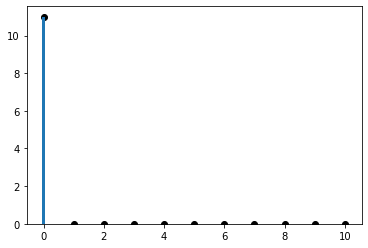

In [183]:
x = np.ones(N) # Time-domain signal

DFT = np.dot(e, x) 
print(f'Amplitude : {np.abs(X)}')

plt.bar(range(N), np.abs(DFT), width=0.1)
plt.scatter(range(N), np.abs(DFT), color='black');

Amplitude : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


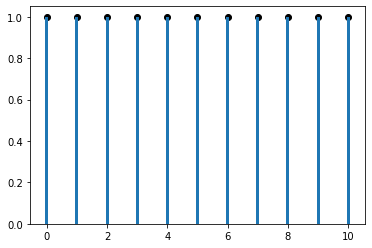

In [184]:
x = np.array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]) # Time-domain signal
DFT = np.dot(e, x) 
print(f'Amplitude : {np.abs(X)}')

plt.bar(range(N), np.abs(DFT), width=0.1)
plt.scatter(range(N), np.abs(DFT), color='black');

Amplitude : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


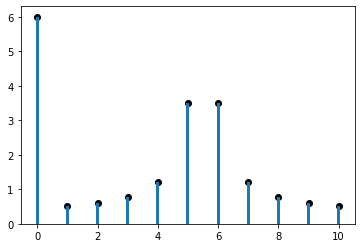

In [185]:
x = np.array([1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1]) # Time-domain signal
DFT = np.dot(e, x) 
print(f'Amplitude : {np.abs(X)}')

plt.bar(range(N), np.abs(DFT), width=0.1)
plt.scatter(range(N), np.abs(DFT), color='black');

Amplitude : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


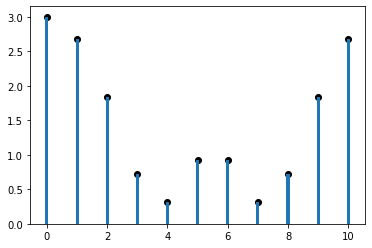

In [187]:
x = np.array([0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0]) # Time-domain signal
DFT = np.dot(e, x) 
print(f'Amplitude : {np.abs(X)}')

plt.bar(range(N), np.abs(DFT), width=0.1)
plt.scatter(range(N), np.abs(DFT), color='black');

Amplitude : [1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]


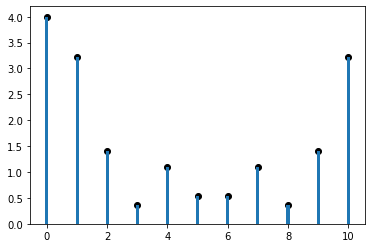

In [188]:
x = np.array([1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1]) # Time-domain signal
DFT = np.dot(e, x) 
print(f'Amplitude : {np.abs(X)}')

plt.bar(range(N), np.abs(DFT), width=0.1)
plt.scatter(range(N), np.abs(DFT), color='black');

## Annexes  

*Notes are written based on link at top of this notebook.*

* **period** : amount of time between two repetitions of signal
* **wavelength** : distance between two repetitions of signal
* **frequency** : how many cycles pass within 1 second
* **amplitude** : height of the signal

Frequency is different from period : 
$$
period = \dfrac{1}{frequency}
$$

A wave is a *continuous* signal, thus, to encode it, one needs to **sample** it, using a *sample rate* (in Hertz).

**Example : sine wave**
$$
y(t) = Asin(\omega t + \phi)
$$
with $A$ the amplitude of the signal, $\omega$ its angular frequency and $\phi$ its phase.  
If $T$ is the period of the wave, then we have 
$$
\omega = \dfrac{2\pi}{T}
$$

### Discrete Fourier Transform - DFT  

A complicated signal in the time domain can be decomposed in a sum of several sinusoids, each with its own frequency. The DFT algorithm transforms a time-domain signal into a figure in the frequency domain called DFT amplitude spectrum, where signal frequencies of each sinusoid are displayed as bars. The result of DFT is a complex number providing information about both amplitude and phase of signal. Usually, one want to focus on amplitude of this signal, and thus takes the absolute value of DFT result. DFT of a time-domain signal is defined as :
$$
X_k = \sum_{n=0}^{N-1} x_n e^{-i \frac{2\pi}{N}nk}
$$
with $N$ the number of samples, $n$ the current sample, $k$ the current frequency ($k \in [0, N-1]$) and $x_n$ the value of the time-domain signal at sample $n$.

If the DFT result shows bars at, 1Hz, 4Hz and 7Hz (for example), it means that the initial time-domain signal was composed of 3 sinusoids with frequencies 1Hz, 4Hz and 7Hz respectively. Note that DFT is symetric.

### Fast Fourier Tranform - FFT  

One major drawback of the DFT algorithm is that it does not scale at all. To solve this problem, [Cooley and Tukey](https://www.ams.org/journals/mcom/1965-19-090/S0025-5718-1965-0178586-1/S0025-5718-1965-0178586-1.pdf) created the Fast Fourier Transform algorithm.